In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
featured_df = pd.read_csv("attendance_with_features.csv")
featured_df.head()

,date,id,rfid_tag,checkin_time,checkout_time,note,DayOfWeek,Lag_1_Status,Count_Telat_7D,Count_Alpa_30D,Streak_Telat,Avg_Arrival_Time_7D
0,2025-09-10,94907,1418C9BC,14:39:32,14:39:40,telat,Wednesday,NaN,0,0,0,NaN
1,2025-09-11,96391,1418C9BC,NaN,NaN,alpa,Thursday,telat,1,0,1,879.533333
2,2025-09-12,97876,1418C9BC,07:22:42,13:50:34,telat,Friday,alpa,1,1,0,879.533333
3,2025-09-13,99361,1418C9BC,NaN,NaN,libur,Saturday,telat,2,1,2,661.116667
4,2025-09-14,100846,1418C9BC,NaN,NaN,libur,Sunday,libur,2,1,0,661.116667


In [ ]:
df_model = featured_df.copy()
df_model['date'] = pd.to_datetime(df_model['date'], errors='coerce')

features = ['Count_Telat_7D', 'Count_Alpa_30D', 'Streak_Telat', 'Avg_Arrival_Time_7D']

df_model['has_checkin'] = df_model['checkin_time'].notna().astype(int)
df_model['Lag_1_Status_filled'] = df_model['Lag_1_Status'].fillna('None')
cat_cols = ['DayOfWeek', 'Lag_1_Status_filled']

X_num = df_model[features + ['has_checkin']].copy()
X_num['Avg_Arrival_Time_7D'] = X_num['Avg_Arrival_Time_7D'].fillna(X_num['Avg_Arrival_Time_7D'].median())

X_cat = pd.get_dummies(df_model[cat_cols].astype(str), prefix=cat_cols, drop_first=True)
X = pd.concat([X_num, X_cat], axis=1)

le = LabelEncoder()

y = df_model['note'].astype(str) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.7,
    missing=-999,
)

xgb_model.fit(X_train, y_train_enc)

y_pred = xgb_model.predict(X_test)

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9246
           1       0.89      0.96      0.92     11407
           2       0.99      0.98      0.99      9402
           3       0.53      0.25      0.34      1852

    accuracy                           0.94     31907
   macro avg       0.85      0.80      0.81     31907
weighted avg       0.93      0.94      0.93     31907



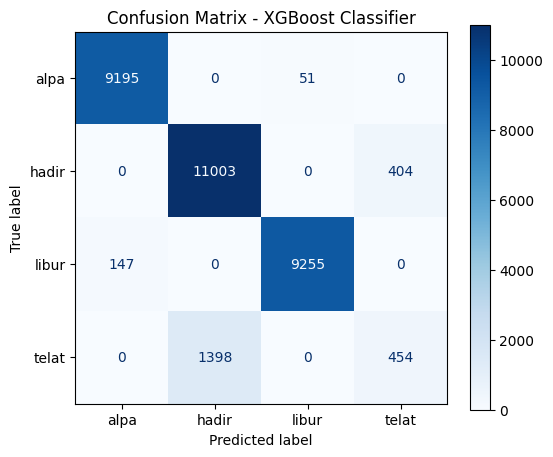

In [24]:
print("Classification report:\n")
print(classification_report(y_test_enc, y_pred, zero_division=0))

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test_enc, display_labels=le.classes_, cmap='Blues', ax=ax)
ax.set_title(f'Confusion Matrix - XGBoost Classifier')
plt.show()

In [16]:

unique_labels = pd.Index(pd.concat([y_test.astype(str), pd.Series(y_pred, index=y_test.index).astype(str)]).unique())
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
y_test_num = y_test.astype(str).map(label_to_int).astype(int).values
y_pred_num = pd.Series(y_pred, index=y_test.index).astype(str).map(label_to_int).astype(int).values

mae = mean_absolute_error(y_test_num, y_pred_num)
mse = mean_squared_error(y_test_num, y_pred_num)
rmse = mse ** 0.5
eps = 1e-9
mape = np.mean(np.abs((y_test_num - y_pred_num) / (y_test_num + eps)))

r2 = r2_score(y_test_num, y_pred_num)
expl_var = explained_variance_score(y_test_num, y_pred_num)
medae = median_absolute_error(y_test_num, y_pred_num)
acc = accuracy_score(y_test_enc, y_pred)

print("\nRegression-style metrics (on integer-encoded labels):")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"R2: {r2:.6f}")
print(f"Explained Variance: {expl_var:.6f}")
print(f"Median AE: {medae:.6f}")
print(f"Accuracy: {acc:.6f}")


Regression-style metrics (on integer-encoded labels):
MAE: 3.903532
RMSE: 3.967714
MSE: 15.742752
MAPE: 1468016424.509883
R2: -16.858726
Explained Variance: 0.426909
Median AE: 4.000000
Accuracy: 0.937318
